In [5]:
"""
Originally from train_stan2.ipynb
train_stan2.ipynb --> train_stan4.ipynb: changed model to only predict future # confirmed cases (as oppsoed to both # confirmed cases and # deaths)
On initial look (when epochs = 50) it looks like model performs equally compared to without changes, but when I trained for more epochs I discovered that
the number of predicted cases gradually became more accurate and larger (but still orders of magnitude smaller than what it should be)

Summary: 
Tried to only predict # confirmed cases (2 output linear layers --> 1 output linear layer) and kept # epochs same (at 50) --> didn't change results too much
Increased epochs --> changed results significantly, but not quickly enough
"""

'\nOriginally from train_stan2.ipynb\n'

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"2. STAN-Without Missing Data"
! pip install epiweeks
! pip install haversine
! pip install dgl

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/2. STAN-Without Missing Data


In [7]:
"""
Import libraries needed
"""
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocess_data_library2 import get_preprocessed_data
from model4 import STAN_v4
from torch import nn

In [8]:
# Get preprocessed data and unpackage variables needed during training/testing/validation

preprocessed_data = get_preprocessed_data()

training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

static_feat = preprocessed_data['static_feat']
loc_list = preprocessed_data['loc_list']
g = preprocessed_data['graph']

train_x = training_variables['train_x']
train_y_confirmed = training_variables['train_y_confirmed']
train_y_deaths = training_variables['train_y_deaths']

val_x = validation_variables['val_x']
val_y_confirmed = validation_variables['val_y_confirmed']
val_y_deaths = validation_variables['val_y_deaths']

test_x = testing_variables['test_x']
test_y_confirmed = testing_variables['test_y_confirmed']
test_y_deaths = testing_variables['test_y_deaths']

Finish download


In [9]:
history_window = 6 # Redeclared from preprocess_data_library
pred_window = 15 # Redeclared from preprocess_data_library
slide_step = 5 # Redeclared from preprocess_data_library

#Build STAN model

in_dim = 4*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN_v4(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [10]:
model

STAN_v4(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=24, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_cumulative_confirmed): Linear(in_features=32, out_features=15, bias=True)
)

In [11]:
train_x = torch.tensor(train_x).to(device)
train_y_confirmed = torch.tensor(train_y_confirmed).to(device)
train_y_deaths = torch.tensor(train_y_deaths).to(device)

val_x = torch.tensor(val_x).to(device)
val_y_confirmed= torch.tensor(val_y_confirmed).to(device)
val_y_deaths = torch.tensor(val_y_deaths).to(device)

test_x = torch.tensor(test_x).to(device)
test_y_confirmed = torch.tensor(test_y_confirmed).to(device)
test_y_deaths = torch.tensor(test_y_deaths).to(device)

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [21]:
#Train STAN_v4

all_loss = []
file_name = './save/stan'
# min_loss = 1e10
min_loss = 1e20

loc_name = 'Kentucky'
cur_loc = loc_list.index(loc_name)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    
    # cumulative_confirmed, cumulative_deaths, _ = model(train_x)
    cumulative_confirmed, _ = model(train_x)
    # loss = criterion(cumulative_confirmed.squeeze(), train_y_confirmed[cur_loc])+criterion(cumulative_deaths.squeeze(), train_y_deaths[cur_loc])
    loss = criterion(cumulative_confirmed.squeeze(), train_y_confirmed[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    # _, _, prev_h = model(train_x)
    _, prev_h = model(train_x)
    # val_cumulative_confirmed, val_cumulative_deaths, _ = model(val_x, prev_h)
    val_cumulative_confirmed, _ = model(val_x, prev_h)
    # val_loss = criterion(val_cumulative_confirmed.squeeze(), val_y_confirmed[cur_loc]) + criterion(val_cumulative_deaths, val_y_deaths[cur_loc])
    val_loss = criterion(val_cumulative_confirmed.squeeze(), val_y_confirmed[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----Save best model-----
Epoch 0, Loss 160352468992.00, Val loss 685776961536.00
-----Save best model-----
Epoch 1, Loss 160352403456.00, Val loss 685776896000.00
-----Save best model-----
Epoch 2, Loss 160352305152.00, Val loss 685776437248.00
-----Save best model-----
Epoch 3, Loss 160352174080.00, Val loss 685776044032.00
-----Save best model-----
Epoch 4, Loss 160352026624.00, Val loss 685775454208.00
-----Save best model-----
Epoch 5, Loss 160352075776.00, Val loss 685775323136.00
-----Save best model-----
Epoch 6, Loss 160351715328.00, Val loss 685775126528.00
-----Save best model-----
Epoch 7, Loss 160351387648.00, Val loss 685774340096.00
-----Save best model-----
Epoch 8, Loss 160351338496.00, Val loss 685773946880.00
-----Save best model-----
Epoch 9, Loss 160351207424.00, Val loss 685773619200.00
-----Save best model-----
Epoch 10, Loss 160351305728.00, Val loss 685773029376.00
-----Save best model-----
Epoch 11, Loss 160350928896.00, Val loss 685772439552.00
Epoch 12, Loss

In [22]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

# Get hidden state from training/validation for use in testing
prev_x = torch.cat((train_x, val_x), dim=1)
# _, _, h = model(prev_x)
_, h = model(prev_x)


# Get predicted values for cumulative confirmed and cumulative deaths
# cumulative_confirmed, cumulative_deaths, _ = model(test_x, h)
cumulative_confirmed, _ = model(test_x, h)


# Real world reported/raw values for # cumulative confirmed and # cumulative deaths
# are test_y_confirmed and test_y_deaths

# Prepare predicted and true values for plotting
predicted_confirmed = cumulative_confirmed.squeeze().detach().numpy()
# predicted_deaths = cumulative_deaths.squeeze().detach().numpy()
true_cumulative_confirmed = test_y_confirmed[cur_loc].squeeze()
# true_cumulative_deaths = test_y_deaths[cur_loc].squeeze()

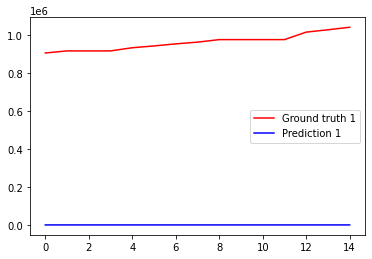

In [23]:
plt.plot(true_cumulative_confirmed,c='r', label='Ground truth 1')
plt.plot(predicted_confirmed,c='b', label='Prediction 1')
plt.legend()
plt.show()

In [24]:
print(predicted_confirmed)
# print(predicted_deaths)
print(true_cumulative_confirmed)
# print(true_cumulative_deaths)

[83.57101  83.78777  83.540726 84.96619  85.10915  84.012924 84.15616
 83.66251  84.14442  84.08284  83.71713  83.10202  83.64532  85.15161
 83.75926 ]
tensor([ 904916.,  915881.,  915881.,  915881.,  932552.,  941986.,  952956.,
         962007.,  975346.,  975346.,  975346.,  975346., 1014703., 1027069.,
        1040420.])
